In [1]:
import os, sys

sys.path.append('..' + os.sep + 'preprocess2')

from common import*

from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

FilterNeurokitWarnings()

In [2]:
BEG_TEST = '..' + os.sep + 'data' + os.sep + 'TestData' + os.sep
BEG_TRAIN = '..' + os.sep + 'preprocess2' + os.sep + PREPROCESSED_DATA + os.sep + str(ELETRODO_IDX) + os.sep

dfAgeSex = pd.read_csv(BEG_TEST + 'attributes.csv')
with h5py.File(BEG_TEST + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])
dfLabels = pd.read_csv(BEG_TEST + 'gold_standard.csv')

def GetTestAge(i):
    return dfAgeSex.values[i][0]

testLabels = dfLabels.values
# deixar as labels na mesma ordem do treino
testLabels[:,4], testLabels[:,5] = testLabels[:,5], testLabels[:,4].copy()

def GetECGAndLabelsInNewAge(ecgAtual, targetAge):
    '''
    retorna o ECG mais próximo no espaço de features na nova idade,
    e as labels dele. Essa função faz tudo do 0 (lê os dados, constrói o modelo (KDTree)),
    então se o mesmo modelo for usado várias vezes, faz sentido parametrizar isso.
    '''
    
    targetAge = min(max(MIN_AGE, targetAge), MAX_AGE)
    
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')
    
    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))
    
    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')
    
    start = BEG_TRAIN + str(targetAge) + os.sep

    mappings = np.load(start + 'mappings.npy')
    ecgs = np.load(start + 'ecgs.npy')
    ondas = np.load(start + 'ondas.npy')
    labels = np.load(start + 'labels.npy')
    
    tree = KDTree(ondas)
    dist, ind = tree.query(coeffs)
    gIdx = dist.argmin()
    idxClosestOnda = ind[gIdx][0]
    ecgOrgRow = mappings[idxClosestOnda]
    ecgClosest = ecgs[ecgOrgRow]
    labelsEcgClosest = labels[ecgOrgRow]
    
    return ecgClosest, labelsEcgClosest

70 [1 1 0 0 0 0]


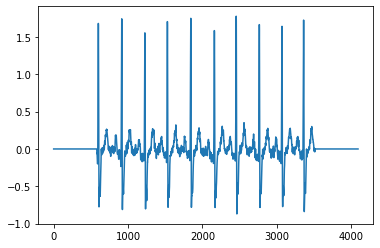

40 [0 0 0 0 0 0]


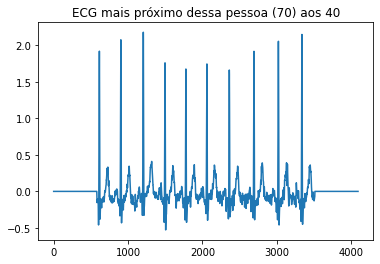

In [22]:
pessoa = 67
ecg = M[pessoa, :, ELETRODO_IDX]
age = GetTestAge(pessoa)
pessoaLabels = testLabels[pessoa]

print(age, pessoaLabels)
plt.plot(ecg)
plt.show()

targetAge = 40
plt.title('ECG mais próximo dessa pessoa (' + str(age) + ') aos ' + str(targetAge))
ecgClosest, labelsEcgClosest = GetECGAndLabelsInNewAge(ecg, targetAge)
print(targetAge, labelsEcgClosest.astype(int))
plt.plot(ecgClosest)
plt.show()

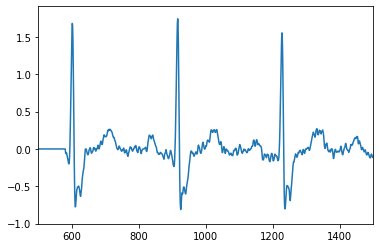

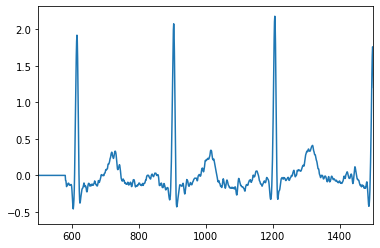

In [29]:
plt.plot(ecg);plt.xlim([500, 1500]);plt.show()
plt.plot(ecgClosest);plt.xlim([500, 1500]);plt.show()

In [4]:
N_TEST = len(M)
targetAge = 40
matched = []
for i in range(N_TEST):
    if i % 50 == 0:
        print(i, '/', N_TEST)
    pessoaLabels = testLabels[i]
    labelsEcgClosest = GetECGAndLabelsInNewAge(ecg, targetAge)[1]
    matched.append(pessoaLabels == labelsEcgClosest)
matched = np.array(matched, dtype=int)

0 / 827
50 / 827
100 / 827
150 / 827
200 / 827
250 / 827
300 / 827
350 / 827
400 / 827
450 / 827
500 / 827
550 / 827
600 / 827
650 / 827
700 / 827
750 / 827
800 / 827


In [5]:
matched

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1]])

In [6]:
(matched.sum(axis=1)==6).sum() # número de pessoas com as mesmas labels exatas

681

In [7]:
# pessoas com algum 1 que tiveram match 100%
idx = []
for i in range(N_TEST):
    if testLabels[i].sum():
        if matched[i].sum() == 6:
            idx.append(i)
idx

[]

In [9]:
testLabels[1].sum()

1

In [20]:
matched[67]

array([0, 0, 1, 1, 1, 1])